In [89]:
import matplotlib.pyplot as plt
import numpy as np
import uproot


from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

In [90]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data


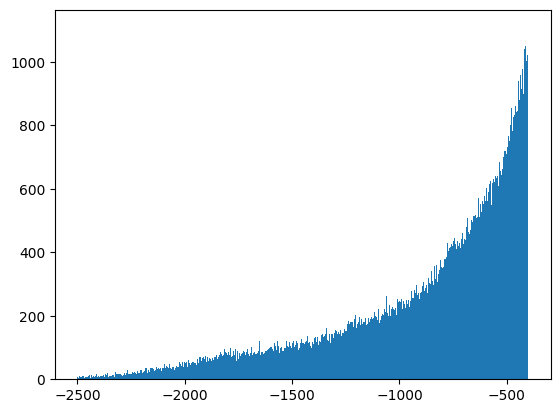

In [147]:
PATH = "../Dati/22-04/Run_chall_X_Measurements_Only_4_22_2024.root"
channel = 3

if channel in [1, 9, 12, 13]:
    raise Exception("Nope!")

lim_list = [[-600, -150],  #ch0
            [-1000, -155],  #ch1
            [-2000, -180],  #ch2
            [-2500, -400],  #ch3
            [-6000, -500],  #ch4
            [-5000, -175],  #ch5
            [-5000, -155],  #ch6
            [-5000, -180],  #ch7
            [-5000, -170],  #ch8
            [-5000, -160],  #ch9
            [-5000, -140],  #ch10
            [-5000, -165],  #ch11
            [-5000, -165],  #ch12
            [-5000, -165],  #ch13
            [-5000, -140],  #ch14
            [-5000, -160]   #ch15
            ]


lim_N = lim_list[channel]


channel_idx = [0, -1, 1, 2, 3, 4, 5, 6, 7, -1, 8, 9, -1, -1, 10, 11]

RunCs = uproot.open(PATH) #Apertura file da analizzare
chargeCs = np.array(RunCs['tree'].arrays()['charge'])

charges = chargeCs[:, channel_idx[channel]]

bin_N, edge_N, _ = plt.hist(charges, bins = 2000, range= lim_N)

err_N = np.sqrt(bin_N)



In [148]:
centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")

err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


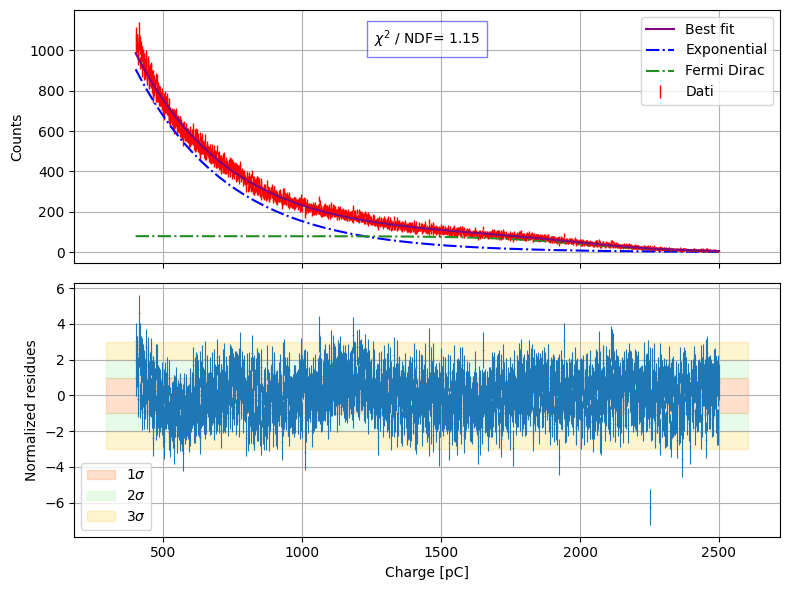

[[Model]]
    (Model(exponential, prefix='e1_') + Model(step, prefix='s1_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 125
    # data points      = 2000
    # variables        = 5
    chi-square         = 2285.96025
    reduced chi-square = 1.14584474
    Akaike info crit   = 277.277990
    Bayesian info crit = 305.282502
    R-squared          = 0.99997780
[[Variables]]
    e1_amplitude:  2967.39626 +/- 32.7191174 (1.10%) (init = 10000)
    e1_decay:     -337.572923 +/- 2.58648385 (0.77%) (init = -200)
    s1_amplitude:  79.2605914 +/- 1.56492262 (1.97%) (init = 1000)
    s1_center:    -2007.52559 +/- 6.89318088 (0.34%) (init = -700)
    s1_sigma:      169.413149 +/- 3.68525944 (2.18%) (init = 299.85)
[[Correlations]] (unreported correlations are < 0.100)
    C(e1_amplitude, e1_decay)     = +0.9598
    C(e1_decay, s1_amplitude)     = +0.8948
    C(s1_amplitude, s1_center)    = +0.8652
    C(s1_center, s1_sigma)        = +0.8316
    C

In [149]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide

 
params = exp1.guess(bin_N, x = centers_N)           #Inizializzo i parametri dell'esponenziale
params.update(sigmoid1.guess(bin_N, x=centers_N))



params["s1_amplitude"].min = 0
params["s1_amplitude"].value = 1000
params["s1_center"].value = -700


params["e1_amplitude"].value = 10000
params["e1_decay"].value = -200

params.update(params)


model = exp1  + sigmoid1   

# Fit the model to the data
result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex = True)
#ax1.set_title(f'{channel = }')



#_ = ax1.bar(centers_N, bin_N, color = "cyan", alpha = 0.5, label = "Background")
#ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()
ax1.errorbar(-centers_N[::-1], bin_N[::-1], err_N[::-1], color = "red", fmt='|', label = "Dati", linewidth = 1, 
             markersize = 0.5,)


comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(-centers_N[::-1], result.best_fit[::-1], label='Best fit', zorder = 10, color = "purple")#, color = "#17BEBB")
ax1.plot(-centers_N[::-1], comps['e1_'][::-1], label='Exponential', ls = "-.", color = "blue")
ax1.plot(-centers_N[::-1], comps['s1_'][::-1], label='Fermi Dirac', ls = "-.", color = "forestgreen")


#dely = result.eval_uncertainty(sigma=3)
#ax1.fill_between(-centers_N[::-1],
#                        (result.best_fit-result.dely)[::-1],
#                        (result.best_fit+result.dely)[::-1],
#                        color="lightblue", alpha = 0.9, label = r'$3\sigma$ band')

ax1.legend()
ax1.grid()
#ax1.set_xlim(-np.array(lim_N))

ax1.text(-np.mean(lim_N), bin_N.max(), f'$\chi^2$ / NDF= {result.redchi:.3}', 
         fontsize=10, color='black', ha = "center", va = "top", 
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='square,pad=0.5'))




residueN = bin_N - result.best_fit
norm_resN = residueN / err_N

ax2.errorbar(-centers_N[::-1], norm_resN[::-1], 1, ls = "", marker = ".", linewidth = 0.8, markersize = 0.5)
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "#FF6700", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "#F7CB15", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "#F7CB15", alpha = 0.2)

ax2.legend()
#ax2.set_xlim(lim_N)
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

In [143]:
N_comp_ratio = float(result.params["e1_amplitude"].value / result.params["s1_amplitude"].value)
print(N_comp_ratio)

24.84575733190303


In [95]:
def get_noise_params(X, Y, err, mdl):
    prm = exp1.guess(Y, x = X)         
    prm.update(sigmoid1.guess(Y, x = X))

    prm["s1_amplitude"].min = 0
    prm["s1_amplitude"].value = 100
    prm.add("ratio", expr = "e1_amplitude / s1_amplitude")

    prm.update(prm)

    rslt = mdl.fit(Y, prm, x = X, weights = 1 / err)

    return rslt.params

In [195]:
edge_N, bin_N = load_histo("../Dati/All_noise_5M.dat")
paramsdict = []
for ch in range(edge_N.shape[0]):
    channel = ch

    lim_N = lim_list[ch]
    edge_N_loop = edge_N[channel]
    bin_N_loop = bin_N[channel]

    rebin_fact = 1
    bin_N_loop = rebin(bin_N_loop, rebin_fact)
    tmp = []
    for i in range(len(edge_N_loop)):
        if(i % rebin_fact == 0):
            tmp.append(edge_N_loop[i])

    tmp.append(edge_N_loop[-1])
    edge_N_loop = np.array(tmp)

    centers_N_loop = np.convolve(edge_N_loop, [0.5, 0.5], "valid")
    err_N_loop = np.sqrt(bin_N_loop)

    err_N_loop = err_N_loop[np.where((centers_N_loop > lim_N[0]) & (centers_N_loop < lim_N[1]))]
    bin_N_loop = bin_N_loop[np.where((centers_N_loop > lim_N[0]) & (centers_N_loop < lim_N[1]))]
    centers_N_loop = centers_N_loop[np.where((centers_N_loop > lim_N[0]) & (centers_N_loop < lim_N[1]))]

    model = exp1 + sigmoid1
   # print(f'{ch = } {get_noise_params(centers_N_loop, bin_N_loop, err_N_loop, model)}')
   
    paramsdict.append(get_noise_params(centers_N_loop, bin_N_loop, err_N_loop, model))



In [196]:
import pickle
from datetime import datetime
current_date = datetime.now()

formatted_date = current_date.strftime("%d_%m")

with open(f'../DictNoise/NoisesDict_{formatted_date}.pkl', 'wb') as f:
    pickle.dump(paramsdict, f)
        